# Nichtlineare Gleichungen

## Nullstellensuche mit SciPy

```python
scipy.optimize.root(f, x0, jac=None, method='hybr')
```
bestimmt eine approximative Lösung der nichtlinearen, multidimensionalen Gleichung
$$f(x) = 0$$
mit Startwert `x0`. Der Algorithmus benötigt die Ableigung $f'$ von $f$, bzw. bei mehrdimensionalen Funktionen die *Jacobi-Matrix* $Df$ mit einträgen
$$(Df)_{ij}(x) = \frac{\partial f_i}{\partial x_j}(x).$$
Diese kann als Funktions-Objekt über den Parameter `jac` übergeben werden. Wird der Parameter ausgelassen, so wird die Jacobi-Matrix numerisch approximiert.

Es gibt eine Reihe von auszuwählenden Algorithmen in `method`. Wir beschränken uns hier auf den Default.

Die Rückgabe der Funktion enthält mehrere Attribute:

* `x` ist die gefundene Lösung
* `fun` Funktionswert bei `x` 
* `nfev` die Anzahl der Funktionsaufrufe. 
* `success` ist `True`, wenn eine Lösung gefunden wurde
* `msg` enthält entweder "converged" oder eine Beschreibung eines aufgetretenen Problems.

### Beispiele

$x \cdot e^x - 1 = 0$

In [1]:
from scipy import optimize as opt
from numpy import exp

def f(x):
    return x * exp(x) - 1

res = opt.root(f, [1], method='hybr')
res

    fjac: array([[-1.]])
     fun: array([  2.22044605e-16])
 message: 'The solution converged.'
    nfev: 9
     qtf: array([ -4.34707825e-11])
       r: array([-2.76322334])
  status: 1
 success: True
       x: array([ 0.56714329])

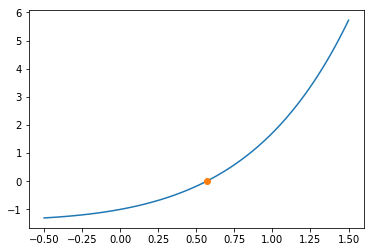

In [1]:
from numpy import ogrid
import matplotlib.pyplot as plt
%matplotlib inline

X = ogrid[-0.5:1.5:100j]
plt.plot(X, f(X), '-', res.x, 0, 'o')

$\begin{cases} x^2 * y = 2 \\ x * y^2 = 1 \end{cases}$

Hier wollen wir auch die Jacobi-Matrix benutzen. Wir rechnen sie hier "per Hand" aus.

In [1]:
from numpy import array

def f(x):
    return array([x[0]**2 * x[1] - 2, 
                  x[0] * x[1]**2 - 1])

def fprime(x):
    return array([[2 * x[0] * x[1], x[0]**2],
                  [x[1]**2, 2 * x[0] * x[1]]])

res = opt.root(f, array([1, 1]), jac=fprime)
res

    fjac: array([[ 0.9732974 ,  0.22954774],
       [-0.22954774,  0.9732974 ]])
     fun: array([  4.44089210e-16,  -7.77156117e-16])
 message: 'The solution converged.'
    nfev: 10
    njev: 1
     qtf: array([  5.69713082e-12,  -5.38941388e-12])
       r: array([ 2.63329335,  3.0994613 ,  1.80833542])
  status: 1
 success: True
       x: array([ 1.58740105,  0.79370053])

Wir haben in ein paar Vorlesungen vorher `SymPy` kennengelernt, wodurch wir Ableitungen symbolisch ausrechnen können. Das nutzen wir nun. Insbesondere bei komplexeren Funktionen/Gleichungen wollen wir die Jacobi-Matrix nicht mehr selbst ausrechnen.

In [1]:
from sympy import symbols
from sympy import Matrix

x, y = symbols ('x,y')
X = Matrix([x**2 * y - 2, x * y**2 - 1])
Y = (x,y)
X.jacobian(Y)

Matrix([
[2*x*y,  x**2],
[ y**2, 2*x*y]])

Die Jacobi-Matrix ist so noch nicht für die numerischen Algorithmen nutzbar. Wir müssen sie wieder mit theano zu einer numerisch auswertbaren Funktion konvertieren. Der 2te Schritt zur Transformierung der Argumente ist nötig, damit sie zu den Anforderungen von `root` passt. 

In [1]:
from sympy.printing.theanocode import theano_function
fjacob = theano_function([x,y],[X.jacobian(Y)])
fjacobs = lambda x: fjacob(x[0],x[1])

Nun können wir diese Funktion mit symbolisch Differenzierter Jacobi-Matrix in unserem Algorithmus nutzen

In [1]:
res = opt.root(f, array([1, 1]), jac=fjacobs)
res

    fjac: array([[ 0.9732974 ,  0.22954774],
       [-0.22954774,  0.9732974 ]])
     fun: array([  4.44089210e-16,  -7.77156117e-16])
 message: 'The solution converged.'
    nfev: 10
    njev: 1
     qtf: array([  5.69713082e-12,  -5.38941388e-12])
       r: array([ 2.63329335,  3.0994613 ,  1.80833542])
  status: 1
 success: True
       x: array([ 1.58740105,  0.79370053])

In [1]:
from numpy import ogrid
from numpy.linalg import norm
from mayavi import mlab as ml
x, y = ogrid[-1:2:100j, -1:2:100j]
fp = lambda x,y: f(array([x,y]))[0]
fp2 = lambda x,y: f(array([x,y]))[1]

ml.surf(x,y,fp, colormap='viridis')
ml.surf(x,y,fp2, colormap='viridis')
ml.points3d(res.x[0], res.x[1], [0], scale_factor=0.4)
ml.title('plot_surf (mayavi)')
ml.colorbar()
ml.show()

6


### Finde Mininum

Finde Minimum 

``` python
scipy.optimize.minimize(func, x0, method=None, jac=None, hess=None, bounds=None, constraints=())
```
- `f`: zu minimierende Funktion
- `x0`: Start-wert/-vektor
- `jac`: jacobian, falls vorhanden
- `bounds`: Grenzen für die Werte
- `constraints`: Nebenbedingungen. Schauen wir uns hier erstmal nicht weiter an.


In [1]:
res2 = opt.minimize(f,1)
print (res2)


## Fixpunkt-Iteration

Gleichungssysteme mit $n$ Gleichungen in $n$ reellen oder komplexen Unbekannten lassen sich durch geeignete Umformungen (auf nicht-eindeutige Weise!) als *Fixpunkt-Gleichung*

$$x = f(x)$$

schreiben mit einer Funktion $f \colon V \to V$ und $V \subset \mathbb{R}^n$ oder $\mathbb{C}^n$ abgeschlossen. Die Existenz und Eindeutigkeit eines Fixpunkts hängt von der konkreten Form von $f$ ab, ist aber z.B. gegeben falls $f$ *kontrahierend* ist, d.h. falls

$$\left\lvert f(x) - f(y)\right\rvert \leq q \left\lvert x - y \right\rvert$$

für alle $x$ und $y$ und ein $q < 1$. Der Beweis dieser Existenz liefert auch ein Verfahren zur approximativen Berechnung eines Fixpunkts, die **Fixpunkt-Iteration**: Für jeden Startwert $x_0 \in V$ konvergiert die durch

$$x_{n+1} = f(x_n)$$

definierte Folge ${(x_n)}_{n \in \mathbb{N}}$ gegen den Fixpunkt.

In [1]:
def fixedpoint(f, x0, tol=1e-4):
    """Fixpunkt-Iteration für f
    
    x0 ist der Startwert. Die Funktion erzeugt einen Generator,
    der in jedem Schritt ein Tupel (x, y, err) liefert, wobei x 
    die aktuelle Iterierte ist, y der Funktionswert und
    
        err = abs(x - f(x))
    
    Die Iteration bricht bei Erreichen der Toleranz ab.
    """
    x = x0
    # Dummy-Wert, um Abbruch vor erster Iteration
    # zu verhindern:
    err = 2*tol
    while err > tol:
        y = f(x)
        err = abs(x - y)
        yield (x, y, err)
        x = y

iteration=0, x=0.2, y=0.9800665778412416, err=0.7800665778412417
iteration=1, x=0.9800665778412416, y=0.5569672528096424, err=0.4230993250315992
iteration=2, x=0.5569672528096424, y=0.8488621656582708, err=0.29189491284862834
iteration=3, x=0.8488621656582708, y=0.660837551116615, err=0.18802461454165575
iteration=4, x=0.660837551116615, y=0.7894784377668683, err=0.1286408866502533
iteration=5, x=0.7894784377668683, y=0.7042157133419932, err=0.08526272442487515
iteration=6, x=0.7042157133419932, y=0.7621195617606609, err=0.05790384841866769
iteration=7, x=0.7621195617606609, y=0.7233741721055711, err=0.03874538965508978
iteration=8, x=0.7233741721055711, y=0.7495765763314931, err=0.026202404225922016
iteration=9, x=0.7495765763314931, y=0.7319774252581913, err=0.01759915107330179
iteration=10, x=0.7319774252581913, y=0.7438542614501144, err=0.011876836191923035
iteration=11, x=0.7438542614501144, y=0.735864198169292, err=0.007990063280822302
iteration=12, x=0.735864198169292, y=0.74125

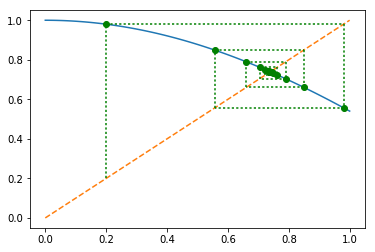

In [1]:
from numpy import ogrid, cos
import matplotlib.pyplot as plt
%matplotlib inline

x_plot = ogrid[0:1:100j]
plt.plot(x_plot, cos(x_plot))
plt.plot(x_plot, x_plot, '--')

# Maximale Anzahl von Iterationen: der `zip`-Iterator endet, sobald
# einer der Iteratoren `range` oder `fixedpoint` fertig ist.
maxit = 30
for n, (x, y, err) in zip(range(maxit), fixedpoint(cos, 0.2)):
    print('iteration={}, x={}, y={}, err={}'.format(n, x, y, err))
    plt.plot(x, y, 'go')
    plt.plot((x, x), (x, y), 'g:')
    plt.plot((x, y), (y, y), 'g:')

Fixpunkt-Iterationen konvergieren oft recht langsam.

Interessiert man sich nur für das End-Ergebnis, also die letzte Iterierte, kann man
```python
for x, err in fixedpoint(f, x0):
    pass
```
verwenden.

Die maximale Iterationszahl kann auch mit `itertools.isclice` festgelegt werden:
```python
for x, err in islice(fixedpoint(f, x0), maxit):
    ...
```

## Newton-Verfahren

Das Newton-Verfahren ist ein iteratives Verfahren zum Berechnen von Nullstellen einer stetig differenzierbaren 
Funktionen $f \colon \mathbb{R}^n \to \mathbb{R}^n$ oder $\mathbb{C}^n \to \mathbb{C}^n$. In jedem Schritt wird die Funktion um den aktuellen Punkt linearisiert und dann der nächste Punkt als Lösung der linearisierten Gleichung gewählt. Statt:

$$f(x) = 0$$

wird also

$$f(x_n) + Df(x_n) (x - x_n) = 0$$

gelöst; die Lösung ist dann $x_{n+1}$. Im 1-dimensionalen Fall (wo $Df = f'$) gilt also:

$$x_{n+1} = x_n - \frac{f(x_n)}{f'(x_n)},$$

d.h. das Newton-Verfahren ist die Fixpunktiteration für $x \mapsto x - \frac{f(x)}{f'(x)}$.

Das Verfahren konvergiert unter geeigneten Bedingungen quadratisch gegen die exakte Lösung von $f(x) = 0$, sofern die Startnäherung $x_0$ nah genug an der Nullstelle liegt. Insbesondere ist es deutlich schneller als die direkt Fixpunkt-Iteration, benötigt aber zusätzlich die Ableitung.

Bei mehreren Nullstellen hängt es von der Startnäherung ab, gegen welche der Nullstellen das Verfahren konvergiert.

In [1]:
# Newton-Iteration als Generator, der (x, y, error)-Werte
# liefert und bei Erreichen der Fehlertoleranz abbricht.
def newton(f, fprime, x0, tol=1e-6):
    """Newton-Iteration für f

    fprime ist die Ableitung, x0 der Startwert. Die Funktion
    erzeugt einen Generator, der in jedem Schritt wird ein
    Tupel (x, y, err) liefert, wobei x die aktuelle Iterierte
    ist, y der Funktionswert und err = abs(y).
    
    Die Iteration bricht bei Erreichen der Toleranz ab.
    """
    x = x0
    while True:
        y = f(x)
        err = abs(y)
        yield (x, y, err)
        if err < tol:
            return
        x = x - y / fprime(x)

**Anmerkung:** `while True` ist oftmals schlechter Stil; Code ist im Allgemeinen besser verständlich, wenn die Abbruchbedingung direkt im `while`-Statement selbst steht. Bei iterativen numerischen Verfahren hat man allerdings oft die Situation, dass erst einige Berechnungen nötig sind, bevor die Abbruchbedingung überprüft werden kann. Will man hier `while True` vermeiden, gibt es zwei Möglichkeiten:

- Die Vorberechnungen können am Ende der jeweils vorhergehenden Iteration ausgeführt werden. Für die erste Iteration muss man sie dann allerdings explizit vor Beginn der Schleife durchführen, man hat also Code-Duplikation.
- Man kann einen boolesche Hilfsvariable `done = False` Einführen, `while not done` verwenden und `done` an der entsprechenden Stelle auf `True` setzen. Das ist dann allerdings (fast) äquivalent zu `return` oder `break`, aber fehleranfälliger und (noch) schwerer verständlich.

In solchen Situationen sind `while True`-Schleifen gerechtfertigt.

In [1]:
from numpy import exp

def f(x):
    return exp(x) - 2
def fprime(x):
    return exp(x)

# Auführen der Newton-Iterationen. Die Punkte werden zur weiteren
# Verwendung in Listen gespeichert.
xs = []
ys = []
# Maximale Anzahl von Iterationen: der `zip`-Iterator endet, sobald
# einer der Iteratoren `range` oder `newton` fertig ist.
maxit = 20
for n, (x, y, err) in zip(range(maxit), newton(f, fprime, 4, tol=1e-10)):
    print('iteration={}, x={}, y={}, err={}'.format(n+1, x, y, err))
    xs.append(x)
    ys.append(y)
if n == maxit-1:
    print('Warning: maximum number of iterations reached.')

iteration=1, x=4, y=52.598150033144236, err=52.598150033144236
iteration=2, x=3.0366312777774684, y=18.834937763928036, err=18.834937763928036
iteration=3, x=2.1326238851306156, y=6.436975447919625, err=6.436975447919625
iteration=4, x=1.369675659471521, y=1.934074508716884, err=1.934074508716884
iteration=5, x=0.8780544396823484, y=0.40621371553564023, err=0.40621371553564023
iteration=6, x=0.7092358044493536, y=0.03243748534577717, err=0.03243748534577717
iteration=7, x=0.6932759111785116, y=0.00025747780941598464, err=0.00025747780941598464
iteration=8, x=0.6931471888453759, y=1.6570861127718217e-08, err=1.6570861127718217e-08
iteration=9, x=0.6931471805599454, y=0.0, err=0.0


Hier eine kleine Visualisierung des Verfahrens. Die gepunkteten Linien sind der Weg von einem x-Wert zum nächsten. 

Funktionswert -> Tangente -> Schnittpunkt mit der Y-Achse -> Funktionswert.

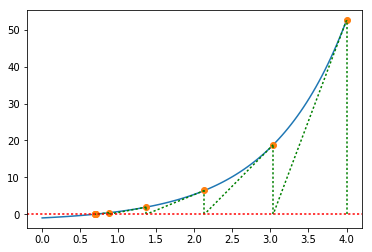

In [1]:
from numpy import log, ogrid
from itertools import count
import matplotlib.pyplot as plt
%matplotlib inline

x_plot = ogrid[0:4:100j]

plt.plot(x_plot, f(x_plot))
plt.plot(xs, ys, 'o')

previous = None
for x, y in zip(xs, ys):
    if previous:
        x_prev, y_prev = previous
        plt.plot((x_prev, x), (y_prev, 0), 'g:')
    plt.plot((x, x), (0, y), 'g:')
    previous = (x, y)

plt.axhline(y=0, color='r', linestyle=':')

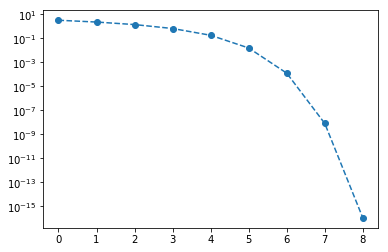

In [1]:
exact_root = log(2)
plt.semilogy([abs(x - exact_root) for x in xs], 'o--')

### Beispiel: Newton-Fraktal

"Das" Newton-Fraktal entsteht beim Betrachten des Newton-Verfahrens für die Funktion

$$f \colon \mathbb{C} \to \mathbb{C}, \quad z \mapsto z^3 - 1.$$

Die Funktion hat drei Nullstellen

$$w_k = \exp\left(\frac{2 \pi i k}{3}\right), \quad k = 0, 1, 2.$$

Das Fraktal entsteht, wenn man Punkte in der komplexen Ebene einfärbt je nach der Nullstelle, gegen die das Newton-Verfahren mit dem gegebenen Punkt als Startnäherung konvergiert. Die Newton-Iteration für `f` ist

$$z_{n+1} = z_n - \frac{z_n^3 - 1}{3z_n^2}.$$

*Anmerkungen*:
- Genau genommen ist das Newton-Fraktal die Grenze zwischen den unterschiedlich eingefärbten Bereichen.
- Ähnlich kann man Newton-Fraktale für andere Funktionen als $z \mapsto z^3 - 1$ betrachten.

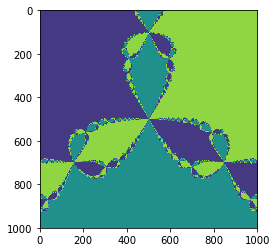

In [1]:
from numpy import ogrid, angle
import matplotlib.pyplot as plt
%matplotlib inline

x, y = ogrid[-1:1:1000j, -1:1:1000j]
z = x + 1j*y

for _ in range(20):
    z = z - (z**3 - 1) / (3*z**2)

plt.imshow(angle(z))